# First Steps
+ Nbstriput should be initialized to extract the metadata on commit. Just comment out the command in the next cell (NBStripout is only requiered if you want to commit, push changes)
+ The folder COVID-19 contains the current data of the John Hopkins CSSE for the 2019-nCoV, these were initialized as submodule, therefore activate the command for the corresponding cell
+ In the 3rd cell the current data from the John Hopkins Repo is pulled 

In [ ]:
# Nbstripout installieren
# !cd ~/corona_jupyternotebooks && nbstripout --install

In [ ]:
# Initialisieren des GIT submoduls
#!cd ~/corona_jupyternotebooks/COVID-19 && git submodule init && git submodule update

In [1]:
# Update Data
!cd ~/corona_jupyternotebooks/COVID-19 && git checkout master && git pull

Already on 'master'
Your branch is up to date with 'origin/master'.
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 0), reused 2 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.
From https://github.com/CSSEGISandData/COVID-19
   d7cbe0a4..8171a1ff  web-data   -> origin/web-data
Already up to date.


In [2]:
# Imports
import os
import glob
import math
import pandas as pd
import numpy as np
# Libraries for visualization
import cufflinks as cf
import ipywidgets
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Read data from John Hopkins into a dataframe
For better visualization it is helpful to build a new dataframe, because e.g. political territory outside the EU is assigned to the administering states with naturally much smaller numbers.
In addition, a clean dataframe helps with further data-moves

In [8]:
# UK is part of it, after all it was once EU
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 
                'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 
                'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']
#Check the file COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv for more countries
non_eu_countries = ['US', 'New Zealand']
countries = eu_countries + non_eu_countries
selected = ipywidgets.SelectMultiple(
    options=countries,
    #value=['Germany'],
    rows=20,
    description='Countries',
    disabled=False
)
print('Select countries to work with. Holding Strg let you select multiple')
display(selected)

Select countries to work with. Holding Strg let you select multiple


SelectMultiple(description='Countries', options=('Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech…

In [10]:
# UK is part of it, after all it was once EU
eu_countries = ['United Kingdom', 'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 
                'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 
                'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']
countries = selected.value
adm_states = ['France', 'United Kingdom', 'Australia', 'Netherlands', 'Denmark']
df_time = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', sep=',') 

pd.to_datetime(df_time.columns[4:], dayfirst=True)

df_series_filter = df_time.drop(['Lat', 'Long'], 1)

df_cleaned = pd.DataFrame()
for c in countries:
    if any(c in col for col in adm_states):
        df_temp = df_series_filter[df_series_filter['Country/Region']==c]
        df_temp = df_temp[df_temp['Province/State'].isnull()].transpose()[2:]
        df_temp.columns = [c]
        temp = df_temp.loc[:, c]
        df_cleaned[c]=temp
        
    else:
        df_temp = df_series_filter[df_series_filter['Country/Region']==c].transpose()[2:]
        df_temp.columns = [c]
        temp = df_temp.loc[:, c]
        df_cleaned[c]=temp
df_cleaned

,France,Germany,US,New Zealand
1/22/20,0,0,1,0
1/23/20,0,0,1,0
1/24/20,2,0,2,0
1/25/20,3,0,2,0
1/26/20,3,0,5,0
...,...,...,...,...
4/1/20,56989,77872,213372,708
4/2/20,59105,84794,243453,797
4/3/20,64338,91159,275586,868
4/4/20,89953,96092,308850,950


# Visualization of infected persons in absolute values
Move Slider to shift the starting date

In [15]:
slide_n = ipywidgets.IntSlider(
    value=0,
    min=0,
    max=60,
    step=1,
    description='Days:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
display(slide_n)

IntSlider(value=0, continuous_update=False, description='Days:', max=60)

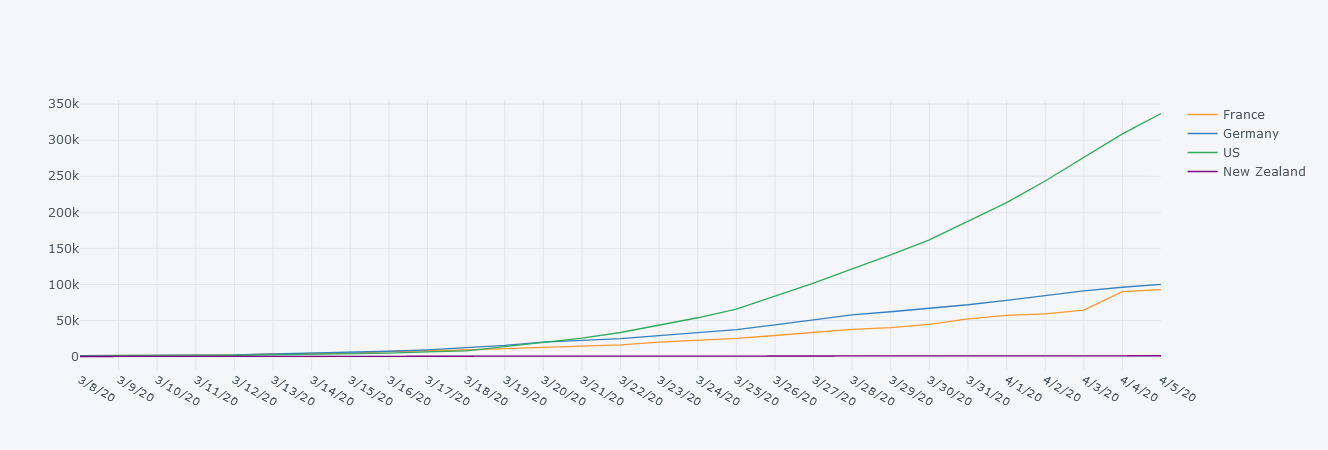

In [19]:
df_cleaned.iloc[slide_n.value:].iplot()

# Decadic logarithm visualisation

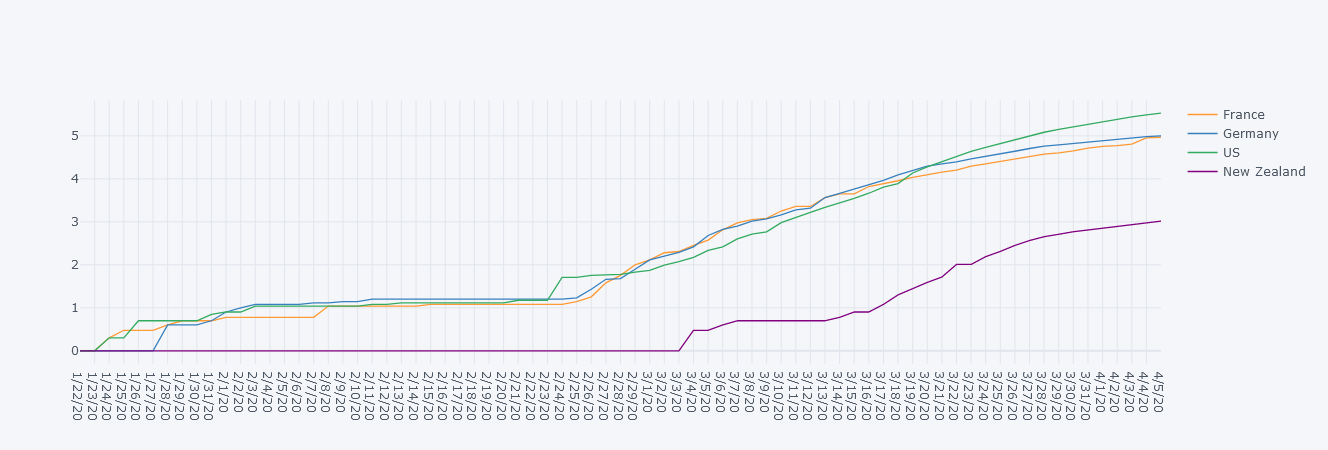

In [20]:
clean_log10 = df_cleaned.copy()
# modify n for shifted start date
n=0
for c in countries:
    clean_log10[c]=clean_log10[c].apply(lambda x: math.log10(x) if x != 0 else 0)
clean_log10.iplot()

# New infections compared to the previous day

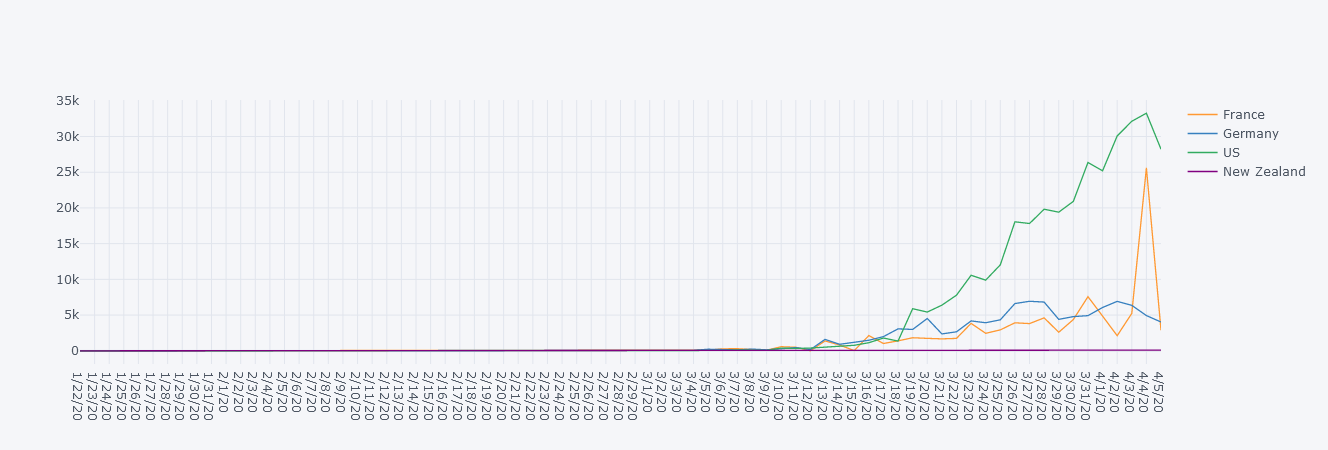

In [21]:
growth = df_cleaned.copy()
# modify n for shifted start date
n=0
for c in countries:    
    growth.loc[:,c].size
    for i in range(growth.loc[:,c].size-1):
        #print(i)
        growth.loc[:,c][i+1]=df_cleaned.loc[:,c][i+1]-df_cleaned.loc[:,c][i]
growth.iloc[n:].iplot()

# Percentage of infected persons in the total population
**IMPORTANT** Population Data is a little bit old (2016)

In [23]:
# Import population data from population.json to dict
import json 
population = {}
with open('population.json') as json_file: 
    data = json.load(json_file)
for c in data:
    population[c['country']] = int(c['population'])

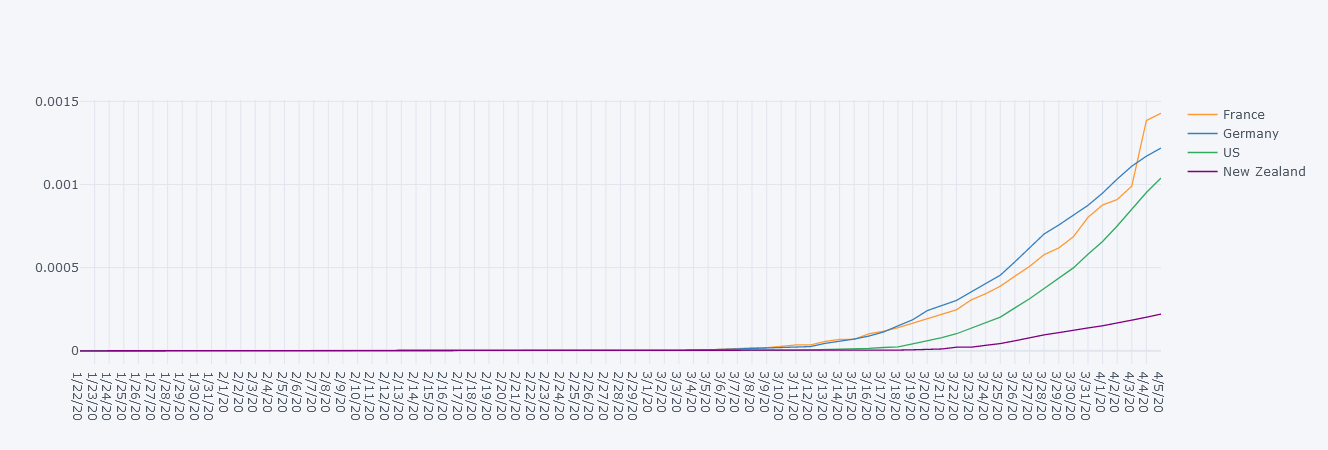

In [24]:
df_percentage = df_cleaned.copy()

for c in countries:
    df_percentage[c]=df_percentage[c].apply(lambda x: x/population[c] if x != 0 else 0)
df_percentage.iplot()